In [1]:
%matplotlib inline

In [2]:
import os
os.chdir("../")

from markowitz.structs import DBCache
from markowitz.layout_parser import from_file
from markowitz import consumme_window
from matplotlib.pyplot import show

def main(db, layout_file):
    layout = from_file(layout_file)

    for window in layout:
        consumme_window(window, db)
    
    show()


db = DBCache("cac40.db")

# Représentation graphique de la Théorie moderne du portefeuille

## Léo Duret & Adrien Chaillout-Morlot

## Introduction
La Théorie Moderne du Portefeuille De Markowitz  est un modèle incontournable des théorie de gestion des actifs.
Il a été proposé en 1952 par l'économiste américain Harry Markowitz, le rendant lauréat d'un prix Nobel en Sciences Economiques. On connait bien les représentations graphiques classiques des portefeuilles à deux titres qui ne font pas parler les nuances des bases de données, et peut etre qu'en apportant des elements de construction de nouveaux graphiques nous pourrons observer de nouvelles choses.



## 1. Modèle

### 1.1 Hypothèses 

#### 1.1.1 Rationalité des agents
La théorie moderne du portefeuille ne propose pas de portefeuille optimal, seulement un ensemble paires risque/rendement optimaux (la frontière efficiente). L'hypotèse de rationnalité implique qu'il existe un seul portefeuille qui maximise l'utilité d'un agent selon sa fonction d'utilité.

#### 1.1.2 Aversion aux risques
Dans le modèle de markowitz le rendement se paie au prix du risque. En effet, l'investisseur n'augmentera son risque seulement si son ésperance de gains augmente 

### 1.2 Rendement-Risque
Les hypotèses en têtes nous pouvons ainsi definir les variables de mesure du rendement et du risque dans le modèle de markowitz.
Tout d'abord on procède à une analyse individuelle des titres en étudiant les variations historiques. Dans notre cas nous avons étudié les titres du CAC40 entre le 20/10/2015 et les 19/10/2015.

Pour un titre possedant $t$ valeurs on calcule la variation entre les valeurs de fermeture du marché:

\begin{align}
    V_t = \ln(X_t) - \ln(X_{t-1})
\end{align}

ainsi que le rendement, soit l'ésperance de variation:

\begin{align}
    \overline{R_{titre}} = E(R_{titre} )=\frac{1}{N}\sum\nolimits_{i=0}^{N}R_i   
\end{align}

Enfin afin de determiner le risque d'un actif calcule l'écart type des variations, que l'on peut interpreter comme étant la volatilité du titre durant la période étudié.

\begin{align}
    \sigma_{titre}=\sqrt{\frac{\mathrm{\sum\nolimits_{i=0}^{N}(R_i-\overline{R_{titre}})^2} }{\mathrm{(N-1)} }   }
\end{align}

### 1.3 Portefeuille
On considère un portefeuille comme étant une collection d'actifs, ainsi par croisements des données on peut observer les matrices de covariance et par extension de corrélation.

On rappelle le calcul de la covariance:

\begin{align}
    cov(R_A,R_B)= E(R_A \cdot R_B ) - E(R_A)\cdot E(R_B)
\end{align}

Et du coefficient de corrélation $\varphi$:

\begin{align} 
    \varphi_{AB}= \frac{\mathrm{cov( R_A \cdot R_B )} }{\mathrm{  \sigma_A \sigma_B } }
\end{align}


Exemple de matrice de covariance pour 3 titres

\begin{pmatrix}
    Var(R_A)&Cov(R_A, R_B)&Cov(R_A, R_C)\\
    Cov(R_B, R_A)&Var(R_B)&Cov(R_B, R_C)\\
    Cov(R_C, R_A)&Cov(R_C, R_B)&Var(R_C)
\end{pmatrix} 

Idem pour la matrice de corrélation

\begin{pmatrix}
    1&\varphi_{AB}&\varphi_{AC}\\
    \varphi_{BA}&1&\varphi_{BC}\\
    \varphi_{CA}&\varphi_{CB}&1
\end{pmatrix} 

In [3]:
p = db.load("renault","axa")

p.recap()


,renault,axa
len,515,515
avg,0.00035596,0.000373932
stdv,0.0197384,0.0188443
COVAR,,
renault,0.000389606,0.00023697
axa,0.00023697,0.000355108
CORR,,
renault,1,0.63709
axa,0.63709,1


### Base de données
Nous avions à notre disposition des fichiers Excel d'actifs du CAC 40.

L'interval est 20/10/2015 - 19/10/2017 pour 515 entrées par tableau, entrées ayant toutes leurs valeurs.

##### Ex: Airliquide


| ISIN         | JOUR       | OUVR     | PHAUT    | PBAS     | CLOT     | VOLUME  |
|--------------|------------|----------|----------|----------|----------|---------|
| FR0000120073 | 20/10/2015 | 100      | 100.1818 | 98.4546  | 99.0909  | 833851  |
| FR0000120073 | 21/10/2015 | 99.6364  | 100.0455 | 98.3636  | 99.6818  | 714208  |
| FR0000120073 | 22/10/2015 | 99.5     | 103.4546 | 99.1818  | 103.0455 | 1264656 |
| FR0000120073 | 23/10/2015 | 104.0454 | 105.9546 | 103.6818 | 105.3636 | 1224405 |



## Transformation

![Capture de la base de donnée et la structure du tableau](img/database_screen.png)

# Efficacité des portefeuilles à 2 titres
## Théorie et Application

### Théorie

Soit deux titres A et B et x la part de titre A tel que

\begin{align}
    0 \leq x \leq 1
\end{align}


On donne le rendement du portefeuille en fonction de x

\begin{align}
    R_P(x)     = x \cdot R_A + (1-x) \cdot R_B
\end{align}


Et sa variance


\begin{array}{lcl}
    Var(R_P) &=& (x \cdot \sigma_A + (1-x) \cdot \sigma_B)^2 \\
    &=& x^2 \cdot Var(R_A) + (1-x)^2 \cdot Var(R_B) + 2 \cdot x \cdot (1-x) \cdot Cov(R_A, R_B)
\end{array}






### La Frontière Efficiente

Il s'agit de l'ensemble des combinaisons optimales d'actifs pour une distribution donnée.

On donne son plan par le systeme suivant:


\begin{cases} 
    R_P(x)     = x \cdot R_A + (1-x) \cdot R_B \\
    \sigma_P(x)= \sqrt{Var(R_P)}
\end{cases}


In [4]:
with open("docs/layouts/layout1.ly") as ly:
    print(ly.read())

! docs/layouts/layout1.ly

& Normal (scale=100) {
	[ NormalGraph(axa) Kde(lvmh) | NormalGraph(lvmh) Kde(lvmh)]
	[              EfficientFrontier(axa/lvmh)                ]
}



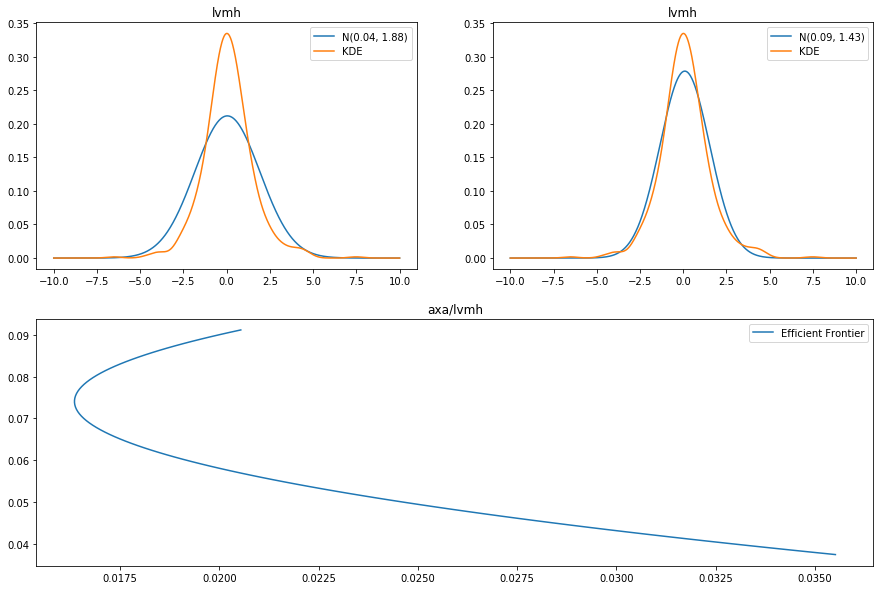

In [5]:
main(db, "docs/layouts/layout1.ly")

# Extension à N titres
## Théorie et application

### Généralisation des équations
Généralisation des l’équation avec $ \alpha $ distribué entre les titres tel que $\sum\alpha_i=1$

#### L'ésperance
\begin{align}
    E(R_p) = \sum_{i=0}^{n}\alpha_i \cdot E(R_i)
\end{align}


##### La variance

\begin{align}
    Var(R_P) = (\sum_{i=0}^{n}\alpha_i \cdot \sigma_i)^2
\end{align}

C'est une forme quadratique d'ordre N donc il existe une matrice symétrique $ N \cdot N $ associée 
Pour 3 titres on trouve

\begin{pmatrix}
     \alpha^2_{1}& \frac{\mathrm{\alpha_1\alpha_2} }{\mathrm{2}} &\frac{\mathrm{\alpha_1\alpha_3} }{\mathrm{2}}\\
    \frac{\mathrm{\alpha_1\alpha_2} }{\mathrm{2}}&\alpha^2_2&\frac{\mathrm{\alpha_2\alpha_3} }{\mathrm{2}}\\
    \frac{\mathrm{\alpha_1\alpha_3} }{\mathrm{2}}&\frac{\mathrm{\alpha_2\alpha_3} }{\mathrm{2}}&\alpha^2_{3}
\end{pmatrix} 


### Calcul de l'écart-type
\begin{align}
    A = M_{quadratique} \cdot M_{covar}\\
\end{align}

La trace de A est la somme des variances pondérés par les $\alpha_i$, soit la variance de $R_p$

\begin{align}
    trace(A)= Var(R_P)
\end{align}

\begin{align}
    \sigma_{R_P} = \sqrt{Var(R_P)} = \sqrt{trace(A)}
\end{align}

### Génération du plan barycentrique
$ E = 
\begin{Bmatrix}
     (x, y, z)  \in  \mathbb{R^3}\setminus x + y + z = 1
\end{Bmatrix} 
$

On fixe un point (en l'occurence z) auquel on retire à plusieur étapes un nombre 's' (1/total_étapes) puis on calcule tous les points x, y qui correspondent à x + y = num_étape*s


![Image de la génération de l'espace](img/rasterizer_screen.png)

In [6]:
with open("docs/layouts/layout2.ly") as ly:
    print(ly.read())

! docs/layouts/layout2.ly

& Normal (scale=100) {
	[ NormalGraph(axa) Kde(lvmh) | NormalGraph(lvmh) Kde(lvmh) | NormalGraph(engie) Kde(engie) ]
	[                              EfficientFrontier(axa/lvmh/engie)                                 ]
}



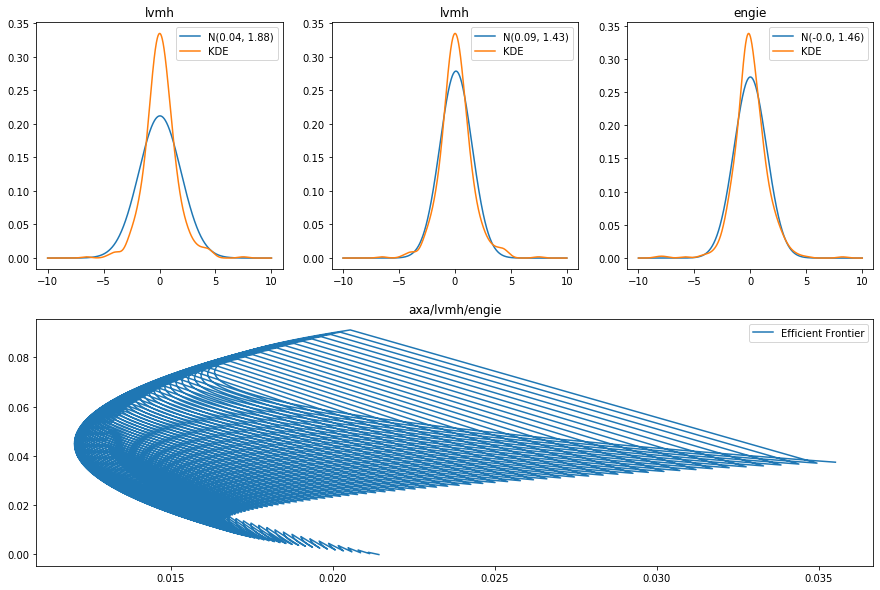

In [7]:
main(db, "docs/layouts/layout2.ly")

# Conclusion
## Critiques et application

### Critiques

- Théorie remise en cause notamment par Benoit Mandelbrot car ce modèle serait trop déconnecté des marchés financiers. En effet la loi de gauss sous évalue la probabilité d'évenements improbables (notamment les krachs boursiers).

- Les suppositions néo-classiques sont irréalistes, les individus ne sont pas rationnels et les variations passé ne se répètent pas dans le futur

### Ouverture

Afin de mieux anticiper les évenements improbables on peut utiliser la loi de pareto ou les lois de puissance.
    

# Merci

### Le code est disponibles sur 
[github.com/hyyking/markowitz](https://github.com/hyyking/markowitz)